<a href="https://colab.research.google.com/github/JordanDCunha/Hands-On-Machine-Learning-with-Scikit-Learn-and-PyTorch/blob/main/Chapter8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Algorithms: k-Means and DBSCAN

Clustering is an **unsupervised learning** task where the goal is to group similar instances together **without labels**.

Unlike classification, clustering algorithms must discover structure in the data on their own.

Clustering is widely used in:
- Customer segmentation
- Data analysis
- Dimensionality reduction
- Feature engineering
- Anomaly detection
- Semi-supervised learning
- Image segmentation

There is no single definition of a “cluster.” Some algorithms look for:
- Centroid-based clusters
- Density-based clusters
- Hierarchical clusters

In this section, we focus on **k-means clustering**.


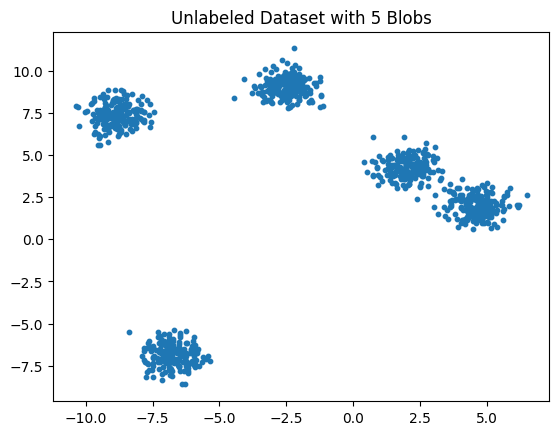

In [51]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate synthetic dataset with 5 clusters
X, y = make_blobs(
    n_samples=1000,
    centers=5,
    cluster_std=0.6,
    random_state=42
)

plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title("Unlabeled Dataset with 5 Blobs")
plt.show()


## k-Means Clustering

k-means is a **centroid-based clustering algorithm**.

It works by:
1. Randomly initializing `k` centroids
2. Assigning each instance to the nearest centroid
3. Updating centroids to be the mean of assigned points
4. Repeating until centroids stop moving

The value of `k` **must be specified in advance**.


In [52]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)

y_pred = kmeans.fit_predict(X)


## Cluster Labels vs Class Labels

In clustering:
- Labels are **discovered**, not provided
- A label is simply a **cluster index**
- Labels have no inherent meaning like class labels

The labels assigned during training are stored in `labels_`.


In [53]:
# First 10 predicted cluster labels
y_pred[:10]


array([2, 2, 0, 2, 4, 0, 3, 4, 2, 4], dtype=int32)

In [54]:
# Centroids found by k-means
kmeans.cluster_centers_


array([[-6.76363502, -6.83888057],
       [-2.52218128,  9.03156916],
       [ 4.61020325,  1.96500287],
       [-8.82929199,  7.37020647],
       [ 2.00893522,  4.23781023]])

## Visualizing k-Means Clusters

k-means partitions space into **Voronoi regions**, where each point belongs to the nearest centroid.

It works best when clusters are:
- Spherical
- Similar in size
- Well separated


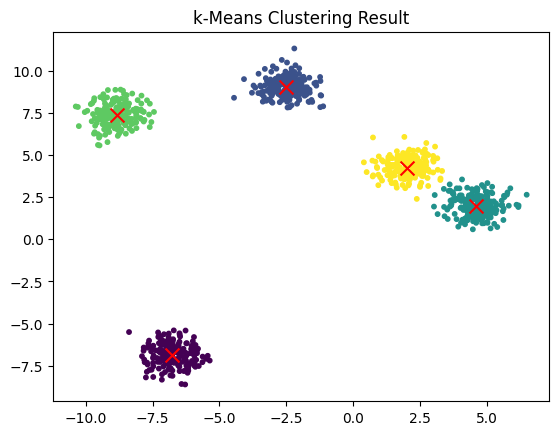

In [55]:
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap="viridis", s=10)
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    c="red",
    marker="x",
    s=100
)
plt.title("k-Means Clustering Result")
plt.show()


## Assigning New Instances to Clusters

Once trained, k-means can assign **new data points** to the nearest centroid.


In [56]:
import numpy as np

X_new = np.array([
    [0, 2],
    [3, 2],
    [-3, 3],
    [-3, 2.5]
])

kmeans.predict(X_new)


array([4, 2, 4, 4], dtype=int32)

## Hard vs Soft Clustering

- **Hard clustering**: each instance belongs to exactly one cluster
- **Soft clustering**: each instance has a score for every cluster

k-means supports soft clustering by measuring distances to centroids.


In [57]:
# Distance from each instance to each centroid
kmeans.transform(X_new).round(2)


array([[11.13,  7.47,  4.61, 10.33,  3.01],
       [13.17,  8.94,  1.61, 12.99,  2.45],
       [10.53,  6.05,  7.68,  7.29,  5.16],
       [10.07,  6.55,  7.63,  7.6 ,  5.3 ]])

This transformation produces a **k-dimensional representation**, which can be used for:
- Nonlinear dimensionality reduction
- Feature engineering
- Feeding into another ML model


## The k-Means Algorithm (Summary)

The algorithm alternates between:
- Assigning instances to the closest centroid
- Updating centroids to the mean of assigned points

The algorithm is guaranteed to converge because the total squared distance to centroids always decreases.

However, it may converge to a **local optimum**, depending on centroid initialization.


## Strengths and Limitations of k-Means

### Strengths
- Very fast and scalable
- Simple and efficient
- Works well for spherical clusters

### Limitations
- Must choose `k` manually
- Sensitive to initialization
- Performs poorly with:
  - Different cluster sizes
  - Non-spherical shapes
  - Outliers


# Centroid Initialization Methods in k-Means

The k-means algorithm is sensitive to centroid initialization. Poor initialization can lead to suboptimal clustering.

There are several strategies to mitigate this issue.


In [58]:
import numpy as np
from sklearn.cluster import KMeans


## Manual Initialization

If you already have a good idea of where centroids should be (for example, from a previous clustering run), you can manually specify them.


In [59]:
good_init = np.array([
    [-3, 3],
    [-3, 2],
    [-3, 1],
    [-1, 2],
    [0, 2]
])

kmeans = KMeans(n_clusters=5, init=good_init, random_state=42)
kmeans.fit(X)


KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, random_state=42)

## Multiple Random Initializations (`n_init`)

Another approach is to run k-means multiple times with different random initializations and keep the best solution.

The `n_init` hyperparameter controls how many times the algorithm runs with different initial centroids.


In [60]:
kmeans = KMeans(
    n_clusters=5,
    init="random",
    n_init=10,
    random_state=42
)

kmeans.fit(X)


KMeans(init='random', n_clusters=5, n_init=10, random_state=42)

## Inertia

To decide which initialization is best, k-means uses **inertia**.

**Inertia** is defined as the sum of squared distances between each instance and its closest centroid.


In [61]:
kmeans.inertia_


698.7711305676509

The `score()` method returns the **negative inertia** (because higher scores are considered better in Scikit-Learn).


In [62]:
kmeans.score(X)


-698.7711305676509

## k-Means++

k-means++ is a smarter centroid initialization algorithm that spreads centroids far apart.

It greatly reduces the risk of poor clustering and usually converges faster.


### k-Means++ Algorithm

1. Choose one centroid randomly from the dataset.
2. Choose the next centroid with probability proportional to the squared distance from the closest existing centroid.
3. Repeat until k centroids are chosen.


In [63]:
kmeans = KMeans(
    n_clusters=5,
    init="k-means++",
    random_state=42
)

kmeans.fit(X)


KMeans(n_clusters=5, random_state=42)

When using k-means++, `n_init` defaults to 1 because initialization quality is already high.


# Accelerated k-Means and Mini-Batch k-Means


## Elkan’s Accelerated k-Means

Elkan’s algorithm speeds up k-means by avoiding unnecessary distance computations using the triangle inequality.

It can speed up training on some datasets, but may slow it down on others.


In [64]:
kmeans = KMeans(
    n_clusters=5,
    algorithm="elkan",
    random_state=42
)

kmeans.fit(X)


KMeans(algorithm='elkan', n_clusters=5, random_state=42)

## Mini-Batch k-Means

Mini-batch k-means uses small random subsets of the data to update centroids.

This allows clustering of very large datasets that do not fit in memory.


In [65]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(
    n_clusters=5,
    random_state=42
)

minibatch_kmeans.fit(X)


MiniBatchKMeans(n_clusters=5, random_state=42)

# Finding the Optimal Number of Clusters


## The Elbow Method

Inertia always decreases as k increases, so we look for an **elbow** in the inertia curve.


## The Elbow Method

Inertia always decreases as k increases, so we look for an **elbow** in the inertia curve.


In [66]:
inertias = []
ks = range(1, 11)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)


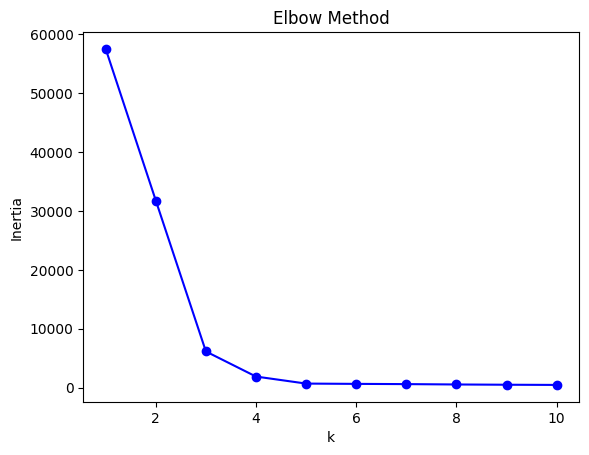

In [67]:
import matplotlib.pyplot as plt

plt.plot(ks, inertias, "bo-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


## Silhouette Score

The silhouette score measures how well instances fit within their cluster compared to other clusters.


In [68]:
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X)

silhouette_score(X, labels)


np.float64(0.7967447329814222)

# Limits of k-Means

k-means struggles when:
- Clusters have different sizes
- Clusters have different densities
- Clusters are non-spherical


Always scale features before using k-means to improve performance.


# Image Segmentation Using k-Means


In [69]:
# extra code – downloads the ladybug image
from pathlib import Path
import urllib.request

homlp_root = "https://github.com/ageron/handson-mlp/raw/main/"
filename = "ladybug.png"
filepath = Path(f"my_{filename}")
if not filepath.is_file():
    print("Downloading", filename)
    url = f"{homlp_root}/images/unsupervised_learning/{filename}"
    urllib.request.urlretrieve(url, filepath)

In [70]:
import PIL.Image as Image

image = np.asarray(Image.open(filepath))
image.shape


(533, 800, 3)

In [71]:
X_pixels = image.reshape(-1, 3)

kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(X_pixels)

segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)


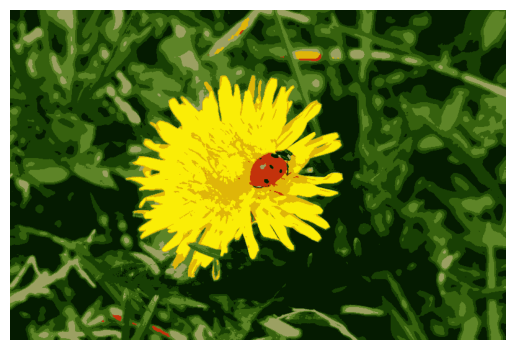

In [72]:
plt.imshow(segmented_img.astype(np.uint8))
plt.axis("off")
plt.show()


# Semi-Supervised Learning with k-Means


In [73]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]


In [74]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

log_reg.score(X_test, y_test)


0.7581863979848866

## Clustering the Training Set


In [75]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)

representative_idx = X_digits_dist.argmin(axis=0)
X_representative_digits = X_train[representative_idx]


(Representative labels are assumed to be manually provided.)


In [76]:
y_representative_digits = np.array([
    8, 0, 1, 3, 6, 7, 5, 4, 2, 8,
    2, 3, 9, 5, 3, 9, 1, 7, 9, 1,
    4, 6, 9, 7, 5, 2, 2, 1, 3, 3,
    6, 0, 4, 9, 8, 1, 8, 4, 2, 4,
    2, 3, 9, 7, 8, 9, 6, 5, 6, 4,
])

In [77]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)

log_reg.score(X_test, y_test)


0.8337531486146096

# Label Propagation


In [78]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)

for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]


In [79]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)

log_reg.score(X_test, y_test)


0.8690176322418136

# DBSCAN


In [80]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(X)


DBSCAN(eps=0.2)

In [81]:
dbscan.labels_


array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,

Instances labeled `-1` are considered anomalies.


In [82]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(
    dbscan.components_,
    dbscan.labels_[dbscan.core_sample_indices_]
)


KNeighborsClassifier(n_neighbors=50)

In [83]:
X_new = np.array([
    [-0.5, 0],
    [0, 0.5],
    [1, -0.1],
    [2, 1]
])

knn.predict(X_new)


array([1, 0, 1, 0])

# Summary

- k-means is fast and scalable but sensitive to initialization and cluster shape
- k-means++ greatly improves reliability
- DBSCAN finds clusters of arbitrary shape and detects anomalies
- Different datasets require different clustering strategies


# Gaussian Mixture Models (GMMs)

A **Gaussian Mixture Model (GMM)** is a probabilistic model that assumes the data was generated from a mixture of several **Gaussian distributions** with unknown parameters.

Each Gaussian represents a **cluster**, and unlike k-means:
- Clusters can be **elliptical**, not just spherical
- Clusters can have **different sizes, orientations, and densities**
- Assignments are **soft** (probabilities), not hard

A GMM assumes:
- There are `k` clusters
- Each cluster `j` has:
  - weight \( \phi^{(j)} \)
  - mean \( \mu^{(j)} \)
  - covariance matrix \( \Sigma^{(j)} \)

Scikit-Learn implements this using the **Expectation-Maximization (EM)** algorithm.


In [84]:
from sklearn.mixture import GaussianMixture

# Fit a Gaussian Mixture Model with 3 clusters
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)


GaussianMixture(n_components=3, n_init=10, random_state=42)

## Learned Parameters

After fitting, the model estimates:
- Cluster weights
- Means
- Covariance matrices


In [85]:
gm.weights_


array([0.58665595, 0.21043353, 0.20291052])

In [86]:
gm.means_


array([[ 0.49067581,  0.2579044 ],
       [ 1.72666283, -0.07241745],
       [-0.74886394,  0.5549146 ]])

In [87]:
gm.covariances_


array([[[ 0.1633683 , -0.09679743],
        [-0.09679743,  0.28719319]],

       [[ 0.06282163,  0.06680095],
        [ 0.06680095,  0.08831191]],

       [[ 0.05311309,  0.06174985],
        [ 0.06174985,  0.08971553]]])

These correspond to:
- **weights** → relative size of each cluster  
- **means** → cluster centers  
- **covariances** → shape and orientation of clusters  


## Expectation–Maximization (EM) Algorithm

The **EM algorithm** alternates between two steps:

### Expectation step (E-step)
Estimate the probability that each instance belongs to each cluster  
(these probabilities are called **responsibilities**).

### Maximization step (M-step)
Update:
- cluster means
- covariance matrices
- cluster weights  

using the responsibilities.

Unlike k-means:
- All points influence all clusters
- Influence is weighted by probability

⚠️ EM can converge to poor local optima, so multiple initializations (`n_init`) are important.


In [88]:
gm.converged_, gm.n_iter_


(True, 15)

## Hard vs Soft Clustering

- **Hard clustering** assigns each instance to the most likely cluster
- **Soft clustering** returns probabilities for each cluster


In [89]:
gm.predict(X)


array([0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 2, 0, 0,
       2, 0, 0, 0, 0, 1, 1, 1, 2, 0, 0, 2, 2, 0, 0, 0, 1, 0, 2, 0, 2, 1,
       2, 0, 1, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0,
       0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 0, 1, 2,
       1, 2, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 2, 2, 2, 0, 1, 2, 2,
       0, 0, 1, 0, 2, 0, 2, 0, 1, 0, 2, 2, 1, 0, 1, 1, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 0, 1, 0,
       2, 0, 1, 0, 1, 0, 0, 2, 1, 0, 2, 1, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0,
       0, 1, 2, 0, 2, 0, 0, 0, 0, 1, 0, 1, 2, 2, 0, 1, 1, 0, 0, 2, 0, 0,
       2, 1, 1, 2, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0,
       2, 2, 0, 1, 1, 0, 0, 2, 2, 2, 1, 2, 0, 0, 0,

In [90]:
gm.predict_proba(X).round(3)


array([[1.   , 0.   , 0.   ],
       [0.999, 0.001, 0.   ],
       [1.   , 0.   , 0.   ],
       ...,
       [0.016, 0.984, 0.   ],
       [0.   , 0.   , 1.   ],
       [1.   , 0.   , 0.   ]])

## Generative Models

GMMs are **generative models**, meaning we can sample new instances from the learned distributions.


In [91]:
X_new, y_new = gm.sample(6)
X_new, y_new


(array([[ 0.75311295,  0.83224471],
        [ 0.48802486,  0.10075663],
        [ 0.27201943,  1.18827386],
        [ 0.78027722,  0.10427621],
        [-0.61544416,  0.66843781],
        [-0.67385613,  0.38762816]]),
 array([0, 0, 0, 0, 2, 2]))

## Density Estimation

The `score_samples()` method returns the **log probability density** at each point.

- Higher value → higher density
- These are **log-PDF values**, not probabilities


In [92]:
gm.score_samples(X).round(2)


array([-1.58, -1.85, -1.58, -1.9 , -0.23, -1.35, -1.59, -1.58, -0.36,
       -1.8 , -1.8 , -1.68, -1.45, -0.49, -0.87,  0.01, -2.18, -0.72,
       -2.  , -0.91, -1.75, -1.76, -0.11, -1.59, -1.53, -1.75, -1.66,
       -1.24, -0.34, -0.56, -0.51, -1.44, -1.82, -2.  ,  0.01, -1.96,
       -1.58, -1.28, -0.3 , -1.58, -1.19, -1.67, -1.06, -1.21, -1.5 ,
       -2.1 , -1.7 , -1.57, -0.31, -0.55, -1.81, -0.91, -1.95, -1.61,
       -1.41, -1.43, -1.57, -1.44, -1.77, -0.65, -2.16, -1.7 , -2.06,
       -1.64, -1.58, -1.53, -1.68, -0.27, -1.65, -1.56, -1.43, -2.1 ,
       -1.64, -1.88, -2.27, -2.14, -1.56, -1.43, -1.72, -0.95, -1.75,
       -1.65, -1.95, -1.3 , -1.33, -1.53, -2.23, -1.72, -1.89, -0.73,
       -0.08, -0.48, -1.23, -1.74, -1.98, -0.5 , -2.09, -1.46, -1.31,
       -0.89, -1.92, -0.65, -0.31, -1.79, -1.67, -1.65, -1.61, -0.53,
       -1.74, -0.02, -1.42, -0.95, -3.76, -1.11, -1.84, -0.12, -1.79,
       -1.79, -1.83, -2.16, -0.63, -0.03, -1.56, -2.22, -2.  , -1.61,
       -1.74, -0.68,

## Covariance Constraints

You can restrict cluster shapes using `covariance_type`:

| Type | Description |
|----|----|
| `"full"` | Any shape, size, orientation (default) |
| `"tied"` | All clusters share the same covariance |
| `"diag"` | Ellipses aligned with axes |
| `"spherical"` | Spheres with different radii |


In [93]:
gm_spherical = GaussianMixture(
    n_components=3,
    covariance_type="spherical",
    n_init=10,
    random_state=42
)

gm_spherical.fit(X)


GaussianMixture(covariance_type='spherical', n_components=3, n_init=10,
                random_state=42)

## Anomaly Detection with GMMs

Instances in **low-density regions** can be treated as anomalies.

A common approach:
1. Compute density scores
2. Choose a percentile threshold (e.g., lowest 2%)
3. Flag points below that threshold


In [94]:
import numpy as np

densities = gm.score_samples(X)
threshold = np.percentile(densities, 2)

anomalies = X[densities < threshold]


## Choosing the Number of Clusters

Gaussian mixtures use **information criteria**:

- **AIC** → favors better fit
- **BIC** → favors simpler models

Lower values are better.


In [95]:
gm.aic(X), gm.bic(X)


(np.float64(2724.853747457196), np.float64(2808.2855871998922))

## Bayesian Gaussian Mixture Models

`BayesianGaussianMixture` can automatically eliminate unnecessary clusters by assigning them near-zero weight.


In [96]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(
    n_components=10,
    n_init=10,
    max_iter=500,
    random_state=42
)

bgm.fit(X)
bgm.weights_.round(2)


array([0.07, 0.15, 0.13, 0.12, 0.14, 0.16, 0.  , 0.11, 0.11, 0.  ])

## Limitations of Gaussian Mixtures

GMMs struggle when clusters:
- Are **non-ellipsoidal**
- Have complex shapes (e.g., two moons)

They may split one cluster into many ellipses.


## Other Anomaly and Novelty Detection Algorithms

Scikit-Learn also provides:

- **EllipticEnvelope** (robust Gaussian fit)
- **Isolation Forest** (random partitioning)
- **Local Outlier Factor (LOF)** (density comparison)
- **One-Class SVM** (novelty detection)
- **PCA reconstruction error**

Each method has different strengths depending on dataset size, dimensionality, and noise.
